<a href="https://colab.research.google.com/github/heerakesavan/CE888-Data-Science-and-Decision-making/blob/Master/Project%20Assignment%201/Project%202/Sentiment_CE888_Model_SVM_by_tuning_on_Validation_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score ,confusion_matrix
import re
import gensim
from gensim import corpora
import pickle
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_extraction import text 
import nltk
import operator
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer,PorterStemmer
from string import punctuation
from nltk.tokenize import word_tokenize
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
from wordcloud import WordCloud
%matplotlib inline
                                                                                        

In [ ]:
df_train = pd.read_fwf('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/train_text.txt', header=None)
df_train.head()
df_train.columns
df_train.count
df_train.isnull().sum()
df_train=df_train.drop([1], axis = 1)
print(df_train.shape)
df_train=df_train.rename(columns={0:"Tweet"})
df_train.head()

(45615, 1)


,Tweet
0,"""QT @user In the original draft of the 7th boo..."
1,"""Ben Smith / Smith (concussion) remains out of..."
2,Sorry bout the stream last night I crashed out...
3,Chase Headley's RBI double in the 8th inning o...
4,@user Alciato: Bee will invest 150 million in ...


In [ ]:
df_train_labels=pd.read_fwf('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/train_labels.txt', header=None)
df_train_labels.head()
print(df_train_labels.shape)
df_train_labels=df_train_labels.rename(columns={0:"Sentiment"})
df_train_labels.head()
#same number of rows in train labels and train text

(9000, 1)


,Sentiment
0,0
1,1
2,1
3,1
4,0


In [ ]:
dfs=[df_train,df_train_labels]
df=pd.concat(dfs, axis=1, join="inner")
dforg=df
df.head()

,Tweet,Sentiment
0,"""QT @user In the original draft of the 7th boo...",0
1,"""Ben Smith / Smith (concussion) remains out of...",1
2,Sorry bout the stream last night I crashed out...,1
3,Chase Headley's RBI double in the 8th inning o...,1
4,@user Alciato: Bee will invest 150 million in ...,0


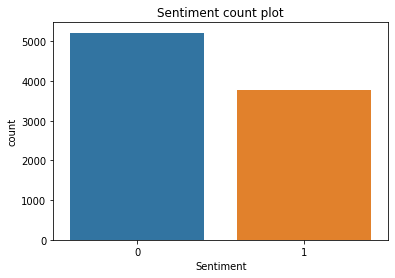

0    5217
1    3783
Name: Sentiment, dtype: int64

In [ ]:
# create countplot for Target column
def createCP(df,x1):
    sns.countplot(x = x1, data = df)
    plt.title('Sentiment count plot')
    plt.show()

x = df.columns.tolist()[-1]   # last column is Target 'sentiment''
createCP(df, "Sentiment")
df["Sentiment"].value_counts()

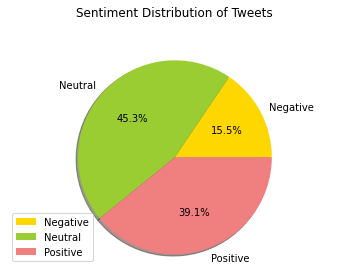

In [ ]:
sentiments = [7093,20673,17849]
colors_list = ['gold', 'yellowgreen', 'lightcoral']
my_labels = 'Negative','Neutral','Positive'
plt.pie(sentiments,labels=my_labels,autopct='%1.1f%%',shadow=True,colors=colors_list)
plt.title('Sentiment Distribution of Tweets', y=1.12) 
plt.axis('equal') 
plt.legend(labels=my_labels, loc='lower left') 
plt.axis('equal')
plt.show()

**Treat Slangs in Tweet**

In order to treat slangs in tweets used abreviations from this link and created slangsdf CSV File: https://www.webopedia.com/reference/text-abbreviations/

In [ ]:
slangs_df = pd.read_csv("/content/drive/MyDrive/slangsdf.csv")
slangs_df.head()

,Slangs,Fullforms
0,?,I have a question
1,?,I don’t understand what you mean
2,?4U,I have a question for you
3,;S,"Gentle warning, like “Hmm? What did you say?”"
4,^^,Meaning “read line” or “read message” above


In [ ]:
def df_to_dict(df,df_dict):
    for index,row in df.iterrows():
        df_dict[row['Slangs']] = row['Fullforms']
    return df_dict

slangs_dict = {}
slangs_dict = df_to_dict(slangs_df,slangs_dict)
slangs_dict['PC'] = "Personal Computer"

def treat_slangs(row,slang_dict):
    words = row.split()
    treated_row = []
    reformed = []
    for word in words:
        if word.upper() in slang_dict.keys():
            new_word = word.replace(word,slang_dict[word.upper()])
            treated_row.append(new_word)
        else:
            treated_row.append(word)
    reformed = " ".join(treated_row)
    return reformed
df['Tweet'] = df['Tweet'].apply(lambda x:treat_slangs(x,slangs_dict))
df.head(2)

,Tweet,Sentiment
0,"""QT @user In the original draft of the 7th boo...",0
1,"""Ben Smith / Smith (concussion) remains out of...",1


**Treating Apostrophes/Contractions in Tweets**

In [ ]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
df['Tweet']=df['Tweet'].apply(lambda x:expand_contractions(x))
df.head(2)
df['Tweet'][0]

'"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"'

**Preprocessing tweets by removing punctuations,urls etc. and Converting to lowercase**

In [ ]:
import string
def clean_text(text):
    #convert the text to lower case
    text = text.lower()
    #remove @mention
    text = re.sub(r'@\w+', '', text)
    #remove Link word
    text = re.sub("{link}",'',text)
    #remove html tags
    text = re.sub("&[\w;]*",' ',text)
    #remove urls
    text = re.sub(r'http.?://[^\s]+[\s]?',' ',text)
    #remove RT
    text = re.sub(r'(?i)\bRT\b','',text)
    #remove content inside square brackets
    text = re.sub('\[.*?\]', ' ', text)
    #remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    #remove digits
    text = re.sub('\d+', ' ',text)
    #remove new line character
    text= re.sub('\n', '', text)
    return text
df["Tweet"]= df.Tweet.apply(lambda x: clean_text(x))
df.Tweet.head(2)
df['Tweet'][0]

'qt  in the original draft of the  th book remus lupin survived the battle of hogwarts happybirthdayremuslupin'

**To remove Emojis, Referred code: https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python**


In [ ]:
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

df["Tweet"]= df.Tweet.apply(lambda x: deEmojify(x))
df.Tweet.head(2)
df['Tweet'][0]

'qt  in the original draft of the  th book remus lupin survived the battle of hogwarts happybirthdayremuslupin'

**Remove StopWords**

In [ ]:
import nltk
nltk.download('stopwords')
def remove_stopwords(input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words)
df["Tweet"]= df.Tweet.apply(lambda x: remove_stopwords(x))
df.Tweet.head(2)
df['Tweet'][0]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


'qt original draft th book remus lupin survived battle hogwarts happybirthdayremuslupin'

**Lemmatization**

In [ ]:
nltk.download('wordnet')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
def lemmatization(input_text):
        words = input_text.split() 
        lemma = WordNetLemmatizer()
        lemma_words = [lemma.lemmatize(i) for i in words]
        return " ".join(lemma_words)
df["Tweet"]= df.Tweet.apply(lambda x: lemmatization(x))
df.Tweet.head(2)
df['Tweet'][0]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


'qt original draft th book remus lupin survived battle hogwarts happybirthdayremuslupin'

**SMOTE for Sampling Imbalanced Dataset and using TF-IDF Vectorizer for text**

In [ ]:
from imblearn.over_sampling import SMOTE,RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
X = df['Tweet']
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(X)
y = df.Sentiment
smote = SMOTE(random_state=40)
X_sm,y_sm = smote.fit_sample(X,y)

**SVM Classification Train Dataset**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import time
from sklearn import svm
from sklearn.svm import SVC  
from sklearn.metrics import classification_report


X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.3, random_state=6)

# defining parameter range
param_grid = {'kernel':['rbf'] } 
  
grid = GridSearchCV(svm.SVC(random_state=0), param_grid,verbose=1,n_jobs=-1)
  
# fitting the model for grid search
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_estimator_)
grid_predictions = grid.predict(X_test)
  
# print classification report
print(classification_report(y_test, grid_predictions))


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.5s finished


{'kernel': 'rbf'}
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)
              precision    recall  f1-score   support

           0       0.60      0.92      0.72      1547
           1       0.84      0.39      0.53      1584

    accuracy                           0.65      3131
   macro avg       0.72      0.66      0.63      3131
weighted avg       0.72      0.65      0.63      3131



**Validation Dataset**




In [ ]:
#Loading Val Dataset
df_val1 = pd.read_fwf('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/val_text.txt', header=None)
df_val1.head()
df_val1.columns
df_val1.count
print(df_val1.isnull().sum())
print(df_val1.shape)
df_val1=df_val1.rename(columns={0:"Tweet"})
df_val1.head()
df_val_labels=pd.read_fwf('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/val_labels.txt', header=None)
df_val_labels.head()
print(df_val_labels.shape)
df_val_labels=df_val_labels.rename(columns={0:"Sentiment"})
df_val_labels.head()
dfs=[df_val1,df_val_labels]
df_val=pd.concat(dfs, axis=1, join="inner")
dfv=df_val
df_val.drop([1],axis=1,inplace=True)
df_val.head()

0       0
1    1989
dtype: int64
(2000, 2)
(2000, 1)


,Tweet,Sentiment
0,Dark Souls 3 April Launch Date Confirmed With ...,1
1,"""National hot dog day, national tequila day, t...",2
2,When girls become bandwagon fans of the Packer...,0
3,@user I may or may not have searched it up on ...,1
4,Here's your starting TUESDAY MORNING Line up a...,1


**Preprocessing the validation Dataset by treating Slangs,Expanding Contractions, Cleaning text by removing punctuations,urls,hashtags etc.,Removing Emojis, lemmatizing and Removing Stopwords**

---



In [ ]:
df_val['Tweet'] = df_val['Tweet'].apply(lambda x:treat_slangs(x,slangs_dict))
df_val.head(2)

,Tweet,Sentiment
0,Dark Souls 3 April Launch Date Confirmed With ...,1
1,"""National hot dog day, national tequila day, t...",2


In [ ]:
df_val['Tweet']=df_val['Tweet'].apply(lambda x:expand_contractions(x))
df_val['Tweet'][0]

'Dark Souls 3 April Launch Date Confirmed With New Trailer: Embrace the darkness.'

In [ ]:
df_val["Tweet"]= df_val.Tweet.apply(lambda x: clean_text(x))
df_val['Tweet'][0]

'dark souls   april launch date confirmed with new trailer embrace the darkness'

In [ ]:
df_val["Tweet"]= df_val.Tweet.apply(lambda x: deEmojify(x))
df_val['Tweet'][0]

'dark souls   april launch date confirmed with new trailer embrace the darkness'

In [ ]:
df_val["Tweet"]= df_val.Tweet.apply(lambda x: remove_stopwords(x))
df_val['Tweet'][0]

'dark souls april launch date confirmed new trailer embrace darkness'

In [ ]:
df_val["Tweet"]= df_val.Tweet.apply(lambda x: lemmatization(x))
df_val['Tweet'][0]

'dark soul april launch date confirmed new trailer embrace darkness'

In [ ]:
df_val["Sentiment"].value_counts()

1    869
2    819
0    312
Name: Sentiment, dtype: int64

**Treating Imbalanced data using SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE,RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
Xv = df_val['Tweet']
tfidf = TfidfVectorizer()
Xv= tfidf.fit_transform(Xv)
yv = df_val.Sentiment
smotev = SMOTE(random_state=42)
X_smv,y_smv = smotev.fit_sample(Xv,yv)


**Hyperparameter tuning on Validation Dataset**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import time
from sklearn import svm
from sklearn.svm import SVC  
from sklearn.metrics import classification_report


X_trainv, X_testv, y_trainv, y_testv = train_test_split(X_smv, y_smv, test_size=0.3, random_state=6)

# defining parameter range
param_grid = {'C': [0,0.01,0.1,0.8,1,1.2,10], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel':['rbf'] } 
  
grid = GridSearchCV(svm.SVC(random_state=0), param_grid,verbose=1,n_jobs=-1,cv = 10)
  
# fitting the model for grid search
grid.fit(X_trainv, y_trainv)
print(grid.best_params_)
print(grid.best_estimator_)
grid_predictions = grid.predict(X_testv)
  
# print classification report
print(classification_report(y_testv, grid_predictions))

Fitting 10 folds for each of 35 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 150 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:  2.4min finished


{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)
              precision    recall  f1-score   support

           0       0.87      0.88      0.87       259
           1       0.56      0.61      0.58       256
           2       0.65      0.59      0.61       268

    accuracy                           0.69       783
   macro avg       0.69      0.69      0.69       783
weighted avg       0.69      0.69      0.69       783



**Loading Test Data**

In [ ]:
#Loading Test Dataset
df_test1 = pd.read_fwf('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/test_text.txt', header=None)
df_test1.head()
df_test1.columns
df_test1.count
print(df_test1.isnull().sum())
print(df_test1.shape)
df_test1=df_test1.rename(columns={0:"Tweet"})
df_test1.head()
df_test_labels=pd.read_fwf('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/test_labels.txt', header=None)
df_test_labels.head()
print(df_test_labels.shape)
df_test_labels=df_test_labels.rename(columns={0:"Sentiment"})
df_test_labels.head()
dfs=[df_test1,df_test_labels]
df_test=pd.concat(dfs, axis=1, join="inner")
dft=df_test
df_test.head()

0    0
dtype: int64
(12284, 1)
(12284, 1)


,Tweet,Sentiment
0,@user @user what do these '1/2 naked pics' hav...,1
1,OH: “I had a blue penis while I was this” [pla...,1
2,"@user @user That's coming, but I think the vic...",1
3,I think I may be finally in with the in crowd ...,2
4,"@user Wow,first Hugo Chavez and now Fidel Cast...",0


**Preprocessing the validation Dataset by treating Slangs,Expanding Contractions, Cleaning text by removing punctuations,urls,hashtags etc.,Removing Emojis, lemmatizing and Removing Stopwords**

---



In [ ]:
df_test['Tweet'] = df_test['Tweet'].apply(lambda x:treat_slangs(x,slangs_dict))
df_test.head(2)

,Tweet,Sentiment
0,@user @user what do these '1/2 naked pics' hav...,1
1,OH: “I had a blue penis while I Wild *a* guess...,1


In [ ]:
df_test['Tweet']=df_test['Tweet'].apply(lambda x:expand_contractions(x))
df_test['Tweet'][0]

"@user @user what do these '1/2 naked pics' have to do with anything? They're not even like that."

In [ ]:
df_test["Tweet"]= df_test.Tweet.apply(lambda x: clean_text(x))
df_test['Tweet'][0]

'  what do these   naked pics have to do with anything theyre not even like that'

In [ ]:
df_test["Tweet"]= df_test.Tweet.apply(lambda x: deEmojify(x))
df_test['Tweet'][0]

'  what do these   naked pics have to do with anything theyre not even like that'

In [ ]:
df_test["Tweet"]= df_test.Tweet.apply(lambda x: remove_stopwords(x))
df_test['Tweet'][0]

'naked pics anything theyre not even like'

In [ ]:
df_test["Tweet"]= df_test.Tweet.apply(lambda x: lemmatization(x))
df_test['Tweet'][0]

'naked pic anything theyre not even like'

In [ ]:
df_test["Sentiment"].value_counts()

1    5937
0    3972
2    2375
Name: Sentiment, dtype: int64

In [ ]:

from sklearn.feature_extraction.text import TfidfVectorizer
Xt = df_test['Tweet']
tfidf = TfidfVectorizer()
Xt= tfidf.fit_transform(Xt)
yt = df_test.Sentiment


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import time
from sklearn import svm
from sklearn.svm import SVC  
from sklearn.metrics import classification_report


X_traint, X_testt, y_traint, y_testt = train_test_split(Xt, yt, test_size=0.3, random_state=6)

# defining parameter range
param_grid = {'kernel':['rbf'] } 

grid = GridSearchCV(svm.SVC(C=10, gamma=0.1,random_state=0), param_grid,n_jobs=-1)
  
# fitting the model for grid search
grid.fit(X_traint, y_traint)
print(grid.best_params_)
print(grid.best_estimator_)
grid_predictions = grid.predict(X_testt)
  
# print classification report
print(classification_report(y_testt, grid_predictions))

{'kernel': 'rbf'}
SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)
              precision    recall  f1-score   support

           0       0.65      0.56      0.60      1243
           1       0.59      0.73      0.65      1713
           2       0.66      0.45      0.54       730

    accuracy                           0.62      3686
   macro avg       0.63      0.58      0.60      3686
weighted avg       0.62      0.62      0.61      3686

